# Лабораторная работа №7: Исследование факторов и организация работы с таблицами данных
Данные: data_purch.xlsx

**Загрузка пакетов**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Загрузка и проверка данных**

In [2]:
data = pd.read_excel('data_purch.xlsx')

# Вывод первых 5 строк
data.head(5)

,first_pub_date,final_protocol_pub_date,purchase_number,collecting_start_date,collecting_end_date,placing_base_name,cust_reg,lot_price_correct,drug_mnn_ext_code,drug_mnn_name,...,drug_position_price,ftg,is_abnd,is_znvlp,is_narcotic,is_msp_purchase,is_povt,is_dif,app_amount_absolute_correct,advance_sum_correct
0,2021-03-30,2021-04-12,AA0000001,2021-03-30,2021-04-07,Электронный аукцион,Республика Адыгея,56040.00,5d6d137c-75b7-11ea-b5ac-1b70cb6e9621,ИНТЕРФЕРОН АЛЬФА-2B,...,56040.00,Иммуномодуляторы,0,1,0,0,0,0,0.0,0.0
1,2021-03-30,2021-04-12,AB0000002,2021-03-30,2021-04-07,Электронный аукцион,Республика Адыгея,57720.00,5d6e26f4-75b7-11ea-b5ac-3b4e2912a2c3,ИНТЕРФЕРОН АЛЬФА-2B,...,57720.00,Иммуномодуляторы,0,1,0,0,0,0,0.0,0.0
2,2021-05-24,2021-06-08,AD0000003,2021-05-24,2021-06-01,Электронный аукцион,Республика Адыгея,931426.86,1edb1f40-bf5b-11e9-bd5d-c33c05f32457,БУДЕСОНИД,...,33096.00,Препараты для лечения обструктивных заболевани...,0,1,0,0,0,0,0.0,0.0
3,2021-05-24,2021-06-08,AD0000003,2021-05-24,2021-06-01,Электронный аукцион,Республика Адыгея,931426.86,1edb3a20-bf5b-11e9-bd5d-07a90f4fd9f6,БУДЕСОНИД+ФОРМОТЕРОЛ,...,225828.00,Препараты для лечения обструктивных заболевани...,0,1,0,0,0,0,0.0,0.0
4,2021-05-24,2021-06-08,AD0000003,2021-05-24,2021-06-01,Электронный аукцион,Республика Адыгея,931426.86,1edb168a-bf5b-11e9-bd5d-5725ca76550a,МОКСОНИДИН,...,10123.68,Препараты гипотензивные,0,1,0,0,0,0,0.0,0.0


In [3]:
# Вывод типов данных
data.dtypes

first_pub_date                 datetime64[ns]
final_protocol_pub_date        datetime64[ns]
purchase_number                        object
collecting_start_date          datetime64[ns]
collecting_end_date            datetime64[ns]
placing_base_name                      object
cust_reg                               object
lot_price_correct                     float64
drug_mnn_ext_code                      object
drug_mnn_name                          object
drug_qty                              float64
drug_price                            float64
drug_position_price                   float64
ftg                                    object
is_abnd                                 int64
is_znvlp                                int64
is_narcotic                             int64
is_msp_purchase                         int64
is_povt                                 int64
is_dif                                  int64
app_amount_absolute_correct           float64
advance_sum_correct               

In [4]:
# Проверка на пропуски
data.isnull().any()

first_pub_date                 False
final_protocol_pub_date        False
purchase_number                False
collecting_start_date          False
collecting_end_date            False
placing_base_name              False
cust_reg                       False
lot_price_correct              False
drug_mnn_ext_code              False
drug_mnn_name                  False
drug_qty                        True
drug_price                     False
drug_position_price             True
ftg                            False
is_abnd                        False
is_znvlp                       False
is_narcotic                    False
is_msp_purchase                False
is_povt                        False
is_dif                         False
app_amount_absolute_correct    False
advance_sum_correct            False
dtype: bool

**Группировка и исследование необходимых переменных**
1. first_pub_date: дата публикации процедуры
2. final_protocol_pub_date: дата завершения процедуры
3. drug_mnn_ext_code: идентификатор лекарственного препарата
4. cust_reg: регион заказчика процедуры
5. placing_base_name: форма проведения торгов
6. is_abnd:  фиктивная переменная: 1 – закупка не состоялась, 0 – состоялась
7. collecting_start_date: дата начала сбора заявок от потенциальных
8. collecting_end_date: дата окончания сбора заявок от потенциальных поставщиков

Сгруппируем данные по purchase_number таким образом, чтобы удостовериться что каждая закупка связана с конкретным регионом и формой торгов

In [5]:
grouped_data = data.groupby('purchase_number').agg({
    'cust_reg': 'nunique',
    'placing_base_name': 'nunique'
})

In [6]:
grouped_data.cust_reg.unique()

array([1], dtype=int64)

In [7]:
grouped_data.placing_base_name.unique()

array([1], dtype=int64)

In [8]:
# Группировка данных по purchase_number
grouped_data = data.groupby('purchase_number').agg({
    'first_pub_date': 'first',
    'final_protocol_pub_date': 'first',
    'collecting_start_date': 'first',
    'collecting_end_date': 'first',
    'drug_mnn_ext_code': 'count',
    'app_amount_absolute_correct': 'first',
    'is_abnd': 'first',
    'cust_reg': 'first',
    'placing_base_name': 'first'
})
# Обновление индекса
grouped_data.reset_index(inplace=True)
# Удаление столбца purchase_number
grouped_data.drop('purchase_number', axis=1, inplace=True)
grouped_data

,first_pub_date,final_protocol_pub_date,collecting_start_date,collecting_end_date,drug_mnn_ext_code,app_amount_absolute_correct,is_abnd,cust_reg,placing_base_name
0,2021-03-30,2021-04-12,2021-03-30,2021-04-07,1,0.0,0,Республика Адыгея,Электронный аукцион
1,2021-06-17,2021-07-02,2021-06-17,2021-06-28,26,0.0,0,Республика Адыгея,Электронный аукцион
2,2021-08-11,2021-08-23,2021-08-11,2021-08-20,15,0.0,1,Республика Адыгея,Электронный аукцион
3,2021-10-07,2021-10-20,2021-10-07,2021-10-15,30,0.0,0,Республика Адыгея,Электронный аукцион
4,2021-08-11,2021-08-24,2021-08-11,2021-08-19,2,0.0,0,Республика Адыгея,Электронный аукцион
...,...,...,...,...,...,...,...,...,...
166841,2021-04-28,2021-05-20,2021-04-28,2021-05-14,2,0.0,0,Город Байконур,Электронный аукцион
166842,2021-06-15,2021-06-29,2021-06-15,2021-06-23,1,0.0,0,Город Байконур,Электронный аукцион
166843,2021-06-15,2021-06-23,2021-06-15,2021-06-23,1,0.0,1,Город Байконур,Электронный аукцион
166844,2021-06-15,2021-06-23,2021-06-15,2021-06-23,2,0.0,1,Город Байконур,Электронный аукцион


**Формирование новых факторов**

In [9]:
# Преобразование категориальной переменной
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

grouped_data["cust_reg_code"] = ord_enc.fit_transform(grouped_data[["cust_reg"]])
grouped_data["placing_base_name_code"] = ord_enc.fit_transform(grouped_data[["placing_base_name"]])

grouped_data.head(5)

,first_pub_date,final_protocol_pub_date,collecting_start_date,collecting_end_date,drug_mnn_ext_code,app_amount_absolute_correct,is_abnd,cust_reg,placing_base_name,cust_reg_code,placing_base_name_code
0,2021-03-30,2021-04-12,2021-03-30,2021-04-07,1,0.0,0,Республика Адыгея,Электронный аукцион,46.0,3.0
1,2021-06-17,2021-07-02,2021-06-17,2021-06-28,26,0.0,0,Республика Адыгея,Электронный аукцион,46.0,3.0
2,2021-08-11,2021-08-23,2021-08-11,2021-08-20,15,0.0,1,Республика Адыгея,Электронный аукцион,46.0,3.0
3,2021-10-07,2021-10-20,2021-10-07,2021-10-15,30,0.0,0,Республика Адыгея,Электронный аукцион,46.0,3.0
4,2021-08-11,2021-08-24,2021-08-11,2021-08-19,2,0.0,0,Республика Адыгея,Электронный аукцион,46.0,3.0


Создадим признаки которые будут описывать временные показатели процедуры  
1. procedure_time: время процедуры в днях
2. collect_time: время сбора заявок в днях
3. month_public_procedure: месяц публикации процедуры

In [10]:
grouped_data['procedure_time'] = (grouped_data['final_protocol_pub_date'] - grouped_data['first_pub_date']).dt.days
grouped_data['collect_time'] = (grouped_data['collecting_end_date'] - grouped_data['collecting_start_date']).dt.days

In [11]:
grouped_data['month_public_procedure'] = grouped_data['first_pub_date'].dt.month

Рассчитаем показатель amount_drug, которые описывает отношение суммы залога к кол-ву препаратов

In [12]:
grouped_data['amount_drug'] = grouped_data['app_amount_absolute_correct'] / grouped_data['drug_mnn_ext_code']

Удалим ненужные столбцы

In [13]:
grouped_data.drop(
    ['final_protocol_pub_date', 'first_pub_date', 
     'collecting_end_date', 'collecting_start_date',
     'drug_mnn_ext_code', 'app_amount_absolute_correct',
     'placing_base_name', 'cust_reg'
    ], axis= 1 , inplace= True)
grouped_data.head()

,is_abnd,cust_reg_code,placing_base_name_code,procedure_time,collect_time,month_public_procedure,amount_drug
0,0,46.0,3.0,13,8,3,0.0
1,0,46.0,3.0,15,11,6,0.0
2,1,46.0,3.0,12,9,8,0.0
3,0,46.0,3.0,13,8,10,0.0
4,0,46.0,3.0,13,8,8,0.0


In [14]:
# Метод главных компонент по 1 компоненте
data_for_pca = grouped_data[['procedure_time', 'collect_time', 'month_public_procedure']].copy()
pca = PCA(n_components=1)
new_feature = pca.fit_transform(data_for_pca)
data_for_pca['PCA'] = new_feature

# Вычисление корреляционной матрицы
corr_matrix = np.corrcoef(data_for_pca, rowvar=False)

# Вычисление собственных значений корреляционной матрицы
eigenvalues = np.linalg.eigvals(corr_matrix)

# Определение оптимального количества компонент
n_components = np.sum(eigenvalues > 1)

# Факторный анализ с оптимальным количеством компонент
fa = FactorAnalysis(n_components=n_components)
fa.fit(data_for_pca)
transformed_data = fa.transform(data_for_pca)

# Добавление нового фактора к исходным данным
data_for_pca['FA'] = transformed_data[:, 0]
data_for_pca

C:\Users\rocks\anaconda3\lib\site-packages\sklearn\decomposition\_factor_analysis.py:288: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


,procedure_time,collect_time,month_public_procedure,PCA,FA
0,13,8,3,-2.608753,-0.385056
1,15,11,6,1.066431,0.157484
2,12,9,8,-2.328152,-0.343744
3,13,8,10,-1.950742,-0.287995
4,13,8,8,-2.138746,-0.315727
...,...,...,...,...,...
166841,22,16,4,9.438754,1.393650
166842,14,8,6,-1.534469,-0.226460
166843,8,8,6,-6.288147,-0.928452
166844,8,8,6,-6.288147,-0.928452


In [15]:
grouped_data['FA'] = data_for_pca['FA']
grouped_data['PCA'] = data_for_pca['PCA']
grouped_data

,is_abnd,cust_reg_code,placing_base_name_code,procedure_time,collect_time,month_public_procedure,amount_drug,FA,PCA
0,0,46.0,3.0,13,8,3,0.0,-0.385056,-2.608753
1,0,46.0,3.0,15,11,6,0.0,0.157484,1.066431
2,1,46.0,3.0,12,9,8,0.0,-0.343744,-2.328152
3,0,46.0,3.0,13,8,10,0.0,-0.287995,-1.950742
4,0,46.0,3.0,13,8,8,0.0,-0.315727,-2.138746
...,...,...,...,...,...,...,...,...,...
166841,0,10.0,3.0,22,16,4,0.0,1.393650,9.438754
166842,0,10.0,3.0,14,8,6,0.0,-0.226460,-1.534469
166843,1,10.0,3.0,8,8,6,0.0,-0.928452,-6.288147
166844,1,10.0,3.0,8,8,6,0.0,-0.928452,-6.288147


**Разделение на обучающую и тестовую выборку**

In [16]:
# Выделение случайной выборки размера n
n = 51000
sample = grouped_data.sample(n)

# Разделение выборки на обучающую и тестовую
test_size = 0.05
train, test = train_test_split(sample, test_size=test_size)

# Разделение выборки на признаки и целевую переменную
X_train, X_test = train.drop('is_abnd', axis=1), test.drop('is_abnd', axis=1)
y_train, y_test = train['is_abnd'], test['is_abnd']
# Количество объектов в обучающей выборке
X_train.shape[0]

48450

**Оценка важности факторов на основе метода "Дерево решений"**

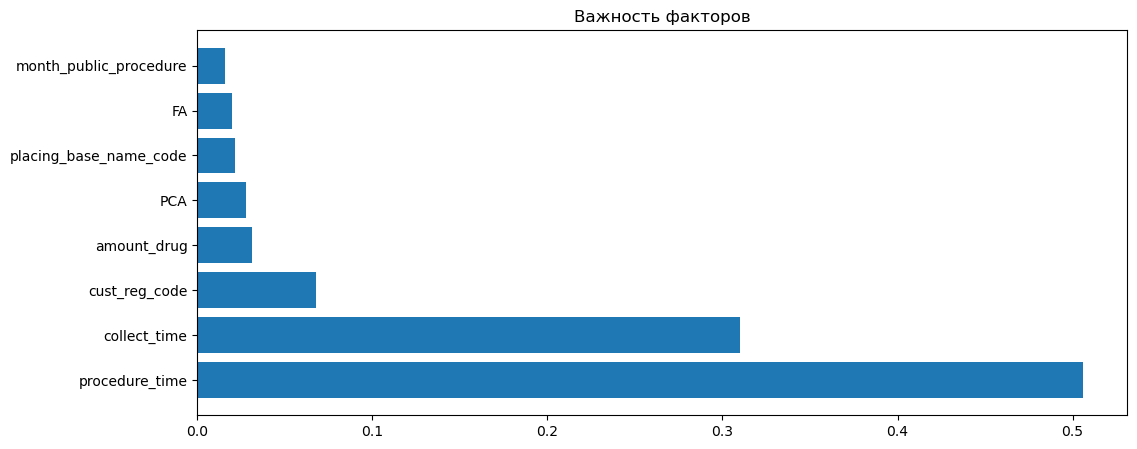

5 важных факторов: ['procedure_time', 'collect_time', 'cust_reg_code', 'amount_drug', 'PCA']


In [17]:
# Создание "Дерево решений" и его обучение
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Получение важности факторов
importances = dt.feature_importances_

# Сохранение важности факторов в датафрейм и сортировка по убыванию
df_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

# Построение графика важности факторов
plt.figure(figsize=(12,5))
plt.barh(df_importances['feature'], df_importances['importance'])
plt.title('Важность факторов')
plt.show()

# Вывод 5 наиболее важных факторов
top_factors = df_importances.head(5)['feature'].values.tolist()
print("5 важных факторов:", top_factors)

5 наиболее важным фактором является PCA, однако он включает в себя первые два, поэтому его следует заменить на placing_base_name_code

In [18]:
# Выбор только 5 наиболее важных факторов в обучающей и тестовой выборке
X_train = X_train[['procedure_time', 'collect_time', 'cust_reg_code', 'amount_drug', 'placing_base_name_code']]
X_test = X_test[['procedure_time', 'collect_time', 'cust_reg_code', 'amount_drug', 'placing_base_name_code']]

In [19]:
# Создание модели логистической регрессии и её обучение
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Предсказание на обучающей и тестовой выборках
train_predictions = logreg.predict(X_train)
test_predictions = logreg.predict(X_test)

# Оценка точности на обучающей и тестовой выборках
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Вывод точности модели на обучающей и тестовой выборках
print("Точность модели на обучающей выборке:", train_accuracy)
print("Точность модели на тестовой выборке:", test_accuracy)

Точность модели на обучающей выборке: 0.4939938080495356
Точность модели на тестовой выборке: 0.49058823529411766


Точность порядка 90% это хороший результат поэтому можно говорить что модель можно использовать для предсказания